# Temperature forecast
![](img/cadreita.jpg)

{octicon}`calendar` Aug, 2025

{bdg-secondary-line}`Time-series forecasting`

## Background
In recent summers, southern Navarra has experienced very hot weather, particularly in the area known as La Ribera, near the banks of the Ebro river. My wife’s father is originally from there, and she remembers that during her childhood holidays, there were also some extremely hot days. But were those summers truly as hot as the ones we experience today? She is also concerned about rising temperatures in the coming years, as she fears the area could become too hot to spend time in. So she asked me to look into the data, and here are the results.

## The data
The weather station I selected is located in Cadreita (42°12'28.0"N, 1°43'05.9"W)  
![](img/map.png)

Daily maximum and minimum temperatures, along with rainfall data, were available in CSV format from 1985 to mid-2025 on this site: https://meteo.navarra.es/estaciones/estacion.cfm?IDEstacion=96  

Since the data could only be downloaded one year at a time, I wrote a script to combine all the files into a single dataset containing the complete series.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm # v2.0.2 -> numpy < 2.0, scikit-learn==1.5.2

# # Script for processing files
# dfs = []
# for year in range(1985, 2026):
#     
#     dfs.append(pd.read_csv(f"data/{year}.csv", sep=";",
#                            usecols=["FECHA", "PRECIPITACION ACUMULADA", "TEMPERATURA MAXIMA", "TEMPERATURA MINIMA"],
#                            parse_dates=["FECHA"], index_col="FECHA", dayfirst=True,
#                            na_values=["- -"],
#                            skiprows=[1],
#                           )
#               )
# 
# df = pd.concat(dfs)
# df.rename(columns={"PRECIPITACION ACUMULADA": "rainfall",
#                    "TEMPERATURA MAXIMA": "tmax",
#                    "TEMPERATURA MINIMA": "tmin"}, inplace=True)
# 
# df.to_csv("data/meteo_cadreita.csv")

df = pd.read_csv("data/meteo_cadreita.csv",
                 parse_dates=["FECHA"], index_col="FECHA",
                )

print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14761 entries, 1985-01-01 to 2025-05-31
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rainfall  14600 non-null  float64
 1   tmax      14532 non-null  float64
 2   tmin      14532 non-null  float64
dtypes: float64(3)
memory usage: 461.3 KB
None


,rainfall,tmax,tmin
FECHA,,,
1985-01-01,0.0,NaN,NaN
1985-01-02,0.0,10.0,4.0
1985-01-03,0.0,12.0,-1.0
1985-01-04,0.0,13.0,-5.5
1985-01-05,3.8,2.5,-5.0
...,...,...,...
2025-05-27,0.0,28.5,10.0
2025-05-28,0.0,31.5,10.0
2025-05-29,0.0,35.0,12.0


## Exploratory analysis

### Yearly temperatures
I subset temperatures from the dataframe, dropping rows with no data.

In [2]:
temps = df[["tmax", "tmin"]].dropna().copy()
print(temps.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14532 entries, 1985-01-02 to 2025-05-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmax    14532 non-null  float64
 1   tmin    14532 non-null  float64
dtypes: float64(2)
memory usage: 340.6 KB
None


I create a new column with the average temperature for the day.

In [3]:
# Daily average column
temps["tavg"] = temps.mean(axis=1)
temps.head()

,tmax,tmin,tavg
FECHA,,,
1985-01-02,10.0,4.0,7.00
1985-01-03,12.0,-1.0,5.50
1985-01-04,13.0,-5.5,3.75
1985-01-05,2.5,-5.0,-1.25
1985-01-07,1.5,-7.0,-2.75


The data for 2025 is incomplete (available only until May 31, 2025), so I will use data up to December 31, 2024, in order to work with full years.

I will then calculate yearly mean values and a moving average of 10 years for filtering, and plot the results.

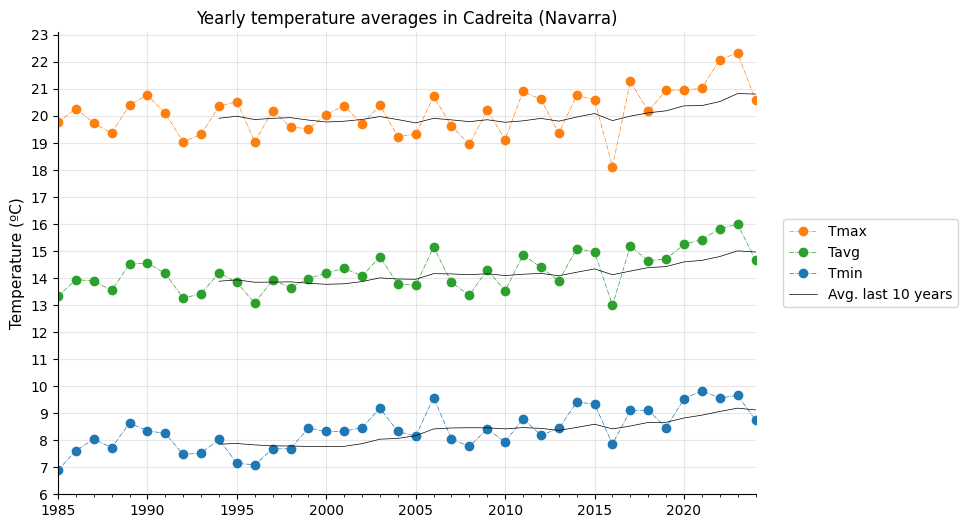

In [4]:
# Discard 2025 temperatures 
temps_upto2024 = temps[temps.index.year < 2025]

# Calculate yearly mean values
yearly_tmin = temps_upto2024.groupby(temps_upto2024.index.year)["tmin"].mean().to_frame()
yearly_tmin.index = pd.to_datetime(yearly_tmin.index, format="%Y")
yearly_tmin = yearly_tmin.asfreq("YS")

yearly_tmax = temps_upto2024.groupby(temps_upto2024.index.year)["tmax"].mean().to_frame()
yearly_tmax.index = pd.to_datetime(yearly_tmax.index, format="%Y")
yearly_tmax = yearly_tmax.asfreq("YS")

yearly_tavg = temps_upto2024.groupby(temps_upto2024.index.year)["tavg"].mean().to_frame()
yearly_tavg.index = pd.to_datetime(yearly_tavg.index, format="%Y")
yearly_tavg = yearly_tavg.asfreq("YS")

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

yearly_tmin.plot(ax=ax, marker="o", linewidth=0.5, linestyle="-.")
yearly_tmax.plot(ax=ax, marker="o", linewidth=0.5, linestyle="-.")
yearly_tavg.plot(ax=ax, marker="o", linewidth=0.5, linestyle="-.")

window = 10 # years considered to calculate moving average
yearly_tmin.rolling(window=window).mean().plot(ax=ax, linewidth=0.5, color="black")
yearly_tmax.rolling(window=window).mean().plot(ax=ax, linewidth=0.5, color="black")
yearly_tavg.rolling(window=window).mean().plot(ax=ax, linewidth=0.5, color="black")

ax.grid(axis="y", alpha=0.3)
ax.grid(axis="x", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.set_ylabel("Temperature (ºC)", size=11)
ax.set_title(f"Yearly temperature averages in Cadreita (Navarra)")
ax.set_yticks(range(6, 24))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[1], handles[2], handles[0], handles[3]],
          labels=["Tmax", "Tavg", "Tmin", f"Avg. last {window} years"],
          bbox_to_anchor=(1.03, 0.5), loc="center left")
sns.despine()
plt.show()

Yearly temperatures have clearly risen over the past 40 years. The moving average indicates an increase of about 1 °C in minimum, maximum, and average temperatures. However, since this smoothing considers the past 10 years, it may understate the impact of the most recent—and hottest—years, meaning the actual increase could be even greater.

### Climate change assesment
Let’s check if climate change is a real phenomenon. For each of the three temperature measures (tmax, tavg, tmin), I will divide the data into two groups by setting a cutoff point—for example, the year 2012.

The year 2012 seems like a good compromise: for the most recent group, it focuses on the last several years, which were more extreme, while still providing enough data points to keep the confidence intervals from becoming too large.

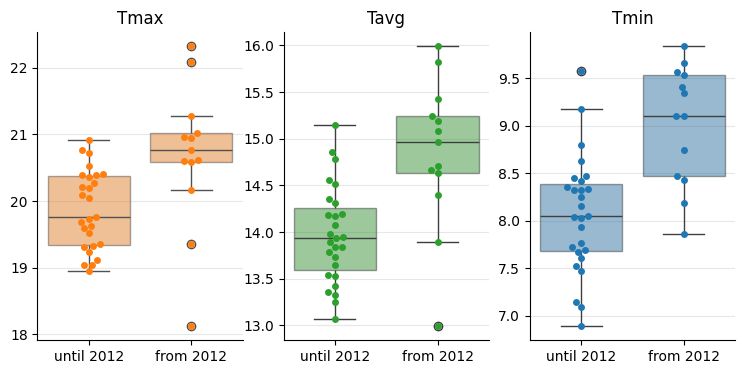

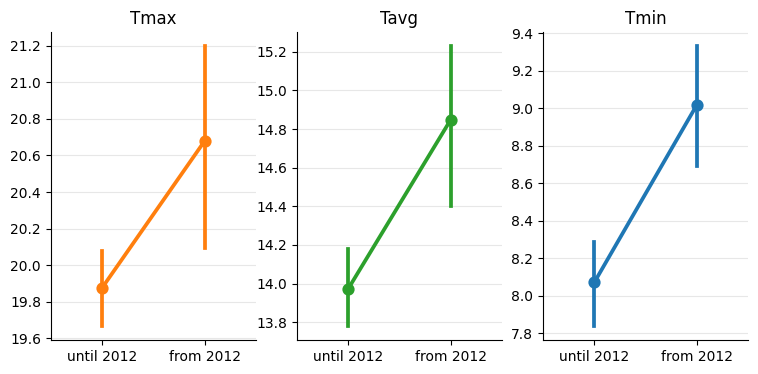

In [5]:
cutoff = 2012 # To divide in two groups

# Subset data series in those groups
yearly_tmin_then = yearly_tmin[yearly_tmin.index.year < cutoff]
yearly_tmin_now = yearly_tmin[yearly_tmin.index.year >= cutoff]

yearly_tmax_then = yearly_tmax[yearly_tmax.index.year < cutoff]
yearly_tmax_now = yearly_tmax[yearly_tmax.index.year >= cutoff]

yearly_tavg_then = yearly_tavg[yearly_tavg.index.year < cutoff]
yearly_tavg_now = yearly_tavg[yearly_tavg.index.year >= cutoff]

# Prepare data to plot in seaborn
tmin_comp = pd.concat([yearly_tmin_then.reset_index(drop=True).rename(columns={"tmin": f"until {cutoff}"}),
           yearly_tmin_now.reset_index(drop=True).rename(columns={"tmin": f"from {cutoff}"})], axis=1).melt().dropna()

tmax_comp = pd.concat([yearly_tmax_then.reset_index(drop=True).rename(columns={"tmax": f"until {cutoff}"}),
           yearly_tmax_now.reset_index(drop=True).rename(columns={"tmax": f"from {cutoff}"})], axis=1).melt().dropna()

tavg_comp = pd.concat([yearly_tavg_then.reset_index(drop=True).rename(columns={"tavg": f"until {cutoff}"}),
           yearly_tavg_now.reset_index(drop=True).rename(columns={"tavg": f"from {cutoff}"})], axis=1).melt().dropna()

# Plot
fig, ax = plt.subplots(1, 3, figsize=(9, 4))

sns.swarmplot(ax=ax[0], x="variable", y="value", data=tmax_comp, color=sns.color_palette("tab10")[1])
sns.swarmplot(ax=ax[1], x="variable", y="value", data=tavg_comp, color=sns.color_palette("tab10")[2])
sns.swarmplot(ax=ax[2], x="variable", y="value", data=tmin_comp, color=sns.color_palette("tab10")[0])

sns.boxplot(ax=ax[0], x="variable", y="value", data=tmax_comp, color=sns.color_palette("tab10")[1], boxprops=dict(alpha=0.5))
sns.boxplot(ax=ax[1], x="variable", y="value", data=tavg_comp, color=sns.color_palette("tab10")[2], boxprops=dict(alpha=0.5))
sns.boxplot(ax=ax[2], x="variable", y="value", data=tmin_comp, color=sns.color_palette("tab10")[0], boxprops=dict(alpha=0.5))

for i in range(3):
    ax[i].grid(axis="y", alpha=0.3)
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

ax[0].set_title("Tmax")
ax[1].set_title("Tavg")
ax[2].set_title("Tmin")

sns.despine()
plt.show()

# Plot
fig, ax = plt.subplots(1, 3, figsize=(9, 4))

sns.pointplot(ax=ax[0], x="variable", y="value", data=tmax_comp, color=sns.color_palette("tab10")[1])
sns.pointplot(ax=ax[1], x="variable", y="value", data=tavg_comp, color=sns.color_palette("tab10")[2])
sns.pointplot(ax=ax[2], x="variable", y="value", data=tmin_comp, color=sns.color_palette("tab10")[0])

for i in range(3):
    ax[i].grid(axis="y", alpha=0.3)
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

ax[0].set_title("Tmax")
ax[1].set_title("Tavg")
ax[2].set_title("Tmin")

sns.despine()
plt.show()

In the plots on the second row, we can clearly see that the confidence intervals for the mean values do not overlap. This provides strong evidence that the data points from each group belong to different distributions—indicating that the climate is indeed changing.

### Days with extreme temperatures
Since daily temperature records are available for all years, let’s calculate the number of days with extreme temperatures. This will serve as a good indicator of the changes taking place in the climate. I will plot the number of days per year with:

- Maximum temperatures reaching 38ºC.
- Minimum temperatures staying above 22ºC ('tropical nights')
- Minimum temperatures dropping below -5ºC.

The reason I chose these temperature thresholds is that they clearly reveal the trends in each graph.

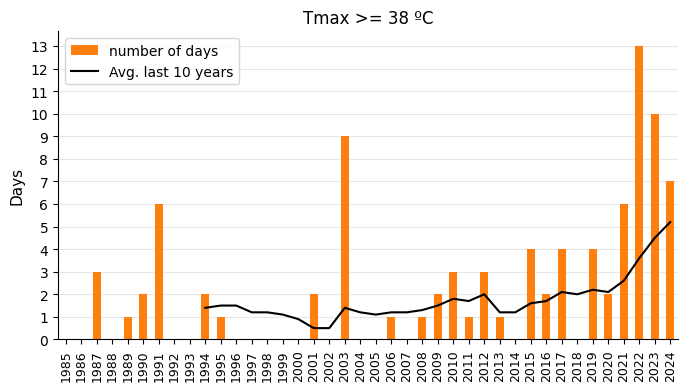

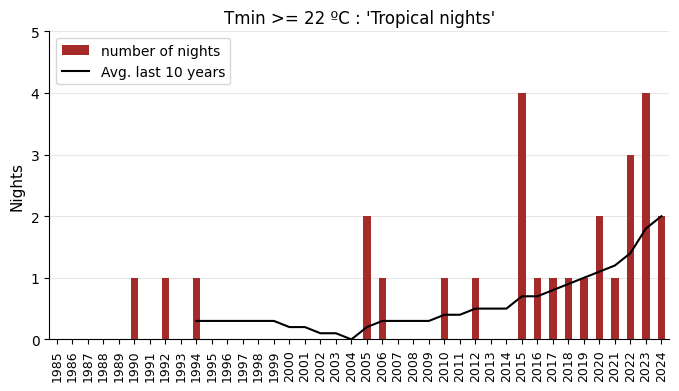

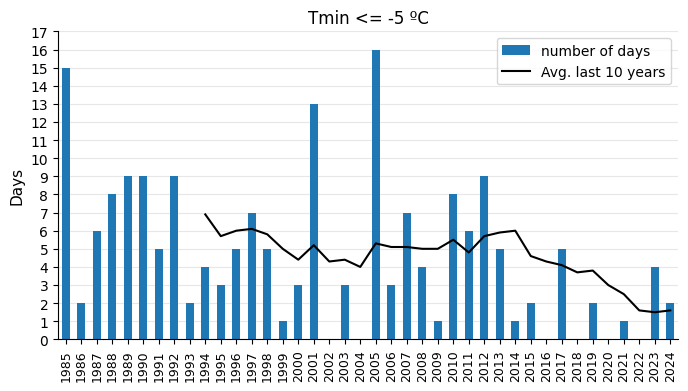

In [6]:
rolling_years = 10 # For the moving average in the graphs

# Plot
tmax = 38
tmax_days = temps.loc[temps["tmax"] >= tmax, ["tmax"]]

tmax_days_count = tmax_days.groupby(tmax_days.index.year).count().rename(columns={"tmax": "tmax_days"})
tmax_days_count.index = pd.to_datetime(tmax_days_count.index, format="%Y")
tmax_days_count = tmax_days_count.reindex(pd.date_range(start="1985-01-01", end="2024-01-01", freq="YS")).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(8, 4))

tmax_days_count.plot(ax=ax, kind="bar", color=sns.color_palette("tab10")[1])
tmax_days_count.rolling(window=rolling_years).mean().reset_index(drop=True).plot(ax=ax, linewidth=1.5, color="black")

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.set_ylabel("Days", size=11)
ax.set_title(f"Tmax >= {tmax} ºC")
x_labels = list(range(1985, 2025))
ax.set_xticks(range(len(x_labels)), labels=x_labels)
ax.set_yticks(range(14))
ax.tick_params(axis='x', labelsize=9, rotation=90)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[handles[1], handles[0]], labels=["number of days", f"Avg. last {rolling_years} years"], loc="upper left")
sns.despine()
plt.show()

# Plot
tmin_above = 22
tmin_above_days = temps.loc[temps["tmin"] >= tmin_above, ["tmin"]]

tmin_above_days_count = tmin_above_days.groupby(tmin_above_days.index.year).count().rename(columns={"tmin": "tmin_above_days"})
tmin_above_days_count.index = pd.to_datetime(tmin_above_days_count.index, format="%Y")
tmin_above_days_count = tmin_above_days_count.reindex(pd.date_range(start="1985-01-01", end="2024-01-01", freq="YS")).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(8, 4))

tmin_above_days_count.plot(ax=ax, kind="bar", color="brown")
tmin_above_days_count.rolling(window=rolling_years).mean().reset_index(drop=True).plot(ax=ax, linewidth=1.5, color="black")

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.set_ylabel("Nights", size=11)
ax.set_title(f"Tmin >= {tmin_above} ºC : 'Tropical nights'")
x_labels = list(range(1985, 2025))
ax.set_xticks(range(len(x_labels)), labels=x_labels)
ax.set_yticks(range(6))
ax.tick_params(axis='x', labelsize=9, rotation=90)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[handles[1], handles[0]], labels=["number of nights", f"Avg. last {rolling_years} years"], loc="upper left")
sns.despine()
plt.show()

# Plot
tmin = -5
tmin_days = temps.loc[temps["tmin"] <= tmin, ["tmin"]]

tmin_days_count = tmin_days.groupby(tmin_days.index.year).count().rename(columns={"tmin": "tmin_days"})
tmin_days_count.index = pd.to_datetime(tmin_days_count.index, format="%Y")
tmin_days_count = tmin_days_count.reindex(pd.date_range(start="1985-01-01", end="2024-01-01", freq="YS")).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(8, 4))

tmin_days_count.plot(ax=ax, kind="bar", color=sns.color_palette("tab10")[0])
tmin_days_count.rolling(window=rolling_years).mean().reset_index(drop=True).plot(ax=ax, linewidth=1.5, color="black")

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.set_ylabel("Days", size=11)
ax.set_title(f"Tmin <= {tmin} ºC")
x_labels = list(range(1985, 2025))
ax.set_xticks(range(len(x_labels)), labels=x_labels)
ax.set_yticks(range(18))
ax.tick_params(axis='x', labelsize=9, rotation=90)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[handles[1], handles[0]], labels=["number of days", f"Avg. last {rolling_years} years"], loc="upper right")
sns.despine()
plt.show()

## Modelling
We will model the data series to predict temperatures in the next few years.

Let’s run the Augmented Dickey-Fuller test to determine whether the time series are stationary or exhibit a statistically significant trend. If a trend is present (as is expected), the differencing orders required to make the series stationary for ARIMA modeling will be calculated.

In [7]:
# Place data series in dictionary to iterate
# Differencing order, d, will be stored in the list
series = {"tmin": [yearly_tmin, None],
          "tmax": [yearly_tmax, None],
          "tavg": [yearly_tavg, None]}

for key, value in series.items():
    # Is it stationary?
    result = adfuller(value[0])
    stationary = result[0] <= result[4]["5%"]
    if stationary:
        series[key][1] = 0
    print(f"'{key}' stationary? {stationary}")

    # If it's not, calculate differencing order
    if not stationary:
        value_diff = value[0]
        for i in range(1, 4): # 3 differencings at most
            value_diff = value_diff.diff().dropna()
            result = adfuller(value_diff)
            stationary = result[0] <= result[4]["5%"]
            if stationary:
                d = i
                break
        series[key][1] = d # Store difference order
        print(f"'{key}' -> difference order d={d}")

'tmin' stationary? False
'tmin' -> difference order d=1
'tmax' stationary? False
'tmax' -> difference order d=2
'tavg' stationary? False
'tavg' -> difference order d=1


According to the difference orders:
- d=2 in tmax would mean a more persistent slope changes.
- d=1 in tmin and tavg would mean the slope stays rather steady.

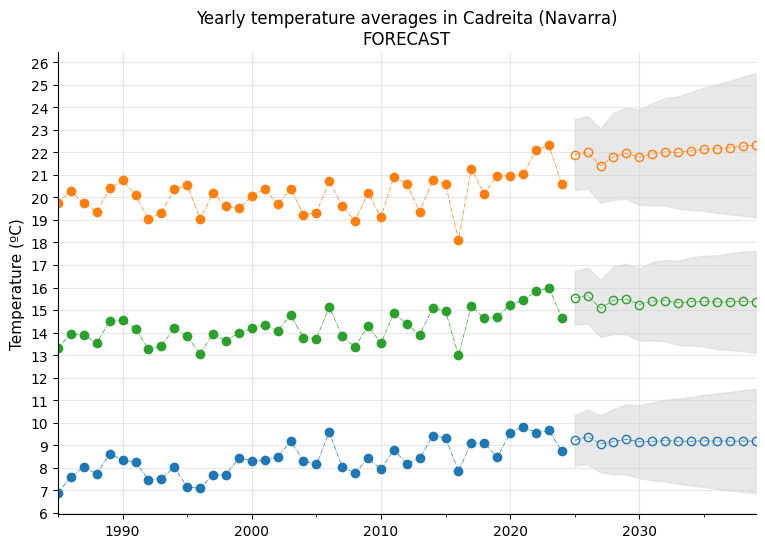

In [8]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))

yearly_tmin.plot(ax=ax, marker="o", linewidth=0.5, linestyle="-.")
yearly_tmax.plot(ax=ax, marker="o", linewidth=0.5, linestyle="-.")
yearly_tavg.plot(ax=ax, marker="o", linewidth=0.5, linestyle="-.")

forecast_years = 15
color_order = 0
for key, value in series.items():
    model = pm.auto_arima(value[0],
                          d=value[1],
                          start_p=0, start_q=0, max_p=3, max_q=3,
                          information_criterion="aic",
                          stepwise=True,
                         )
    
    forecast = model.predict(n_periods=forecast_years, return_conf_int=True, alpha=0.05)
    forecast[0].plot(ax=ax, marker="o", color=sns.color_palette("tab10")[color_order], fillstyle="none", linewidth=0.5, linestyle="-.")
    ax.fill_between(forecast[0].index, forecast[1][:, 0], forecast[1][:, 1], color="lightgrey", alpha=0.5)
    color_order += 1

ax.grid(axis="y", alpha=0.3)
ax.grid(axis="x", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.set_ylabel("Temperature (ºC)", size=11)
ax.set_title(f"Yearly temperature averages in Cadreita (Navarra)\nFORECAST")
ax.set_yticks(range(6, 27))
ax.legend().remove()
sns.despine()
plt.show()

Based on the modeling and the 15-year forecast, it is quite clear that rising temperatures are here to stay.  
One conclusion from the graph is that maximum temperatures appear to exhibit a little bit more pronounced upward trend, although confidence intervals are also wider, suggesting a bit more unpredictability than minimum temperatures.

## Conclusion
It seems obvious that temperatures are rising, so even though my wife remembers very hot summers in the 1980s, they are now even hotter in this area. Does this mean that spending holidays there will become unbearable in the long term? Who knows. For now, the best we can do is monitor the temperatures to see where we’re headed—and, alternatively, invest in an air conditioning system and stay indoors with the shades drawn during heatwaves.